In [2]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
yf.pdr_override()
from datetime import datetime
import copy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import data_util  
from sklearn.preprocessing import MinMaxScaler

In [3]:
from Evaluation_metrics import *
def evaluate_metrics(y_true, y_pred):
    results = {
        'Metric': ['MAPE', 'MAE', 'MSE', 'RMSE', 'R2', 'SMAPE'],
        'Value': [MAPE(y_true, y_pred), 
                  MAE(y_true, y_pred), 
                  MSE(y_true, y_pred), 
                  RMSE(y_true, y_pred), 
                  R2(y_true, y_pred), 
                  SMAPE(y_true, y_pred)]
    }
    df = pd.DataFrame(results)
    
    # Add dotted lines
    dotted_style = [dict(selector="th", props=[("border-bottom", "1px dotted #aaaaaa")]),
                    dict(selector="td", props=[("border-bottom", "1px dotted #aaaaaa")])]
    
    # Apply styling
    styled_df = (df.style
                 .set_properties(**{'text-align': 'center'})
                 .format({'Value': '{:.2f}'})  # Round values to 2 decimal places
                 .set_table_styles(dotted_style)
                 .set_caption('Evaluation Metrics')
                 .set_table_attributes('style="border-collapse: collapse; border: none;"')
                 .set_properties(subset=['Metric'], **{'font-weight': 'bold',}))  # Bold and blue headers
    
    return styled_df

from keras.callbacks import Callback

# Custom callback to display output every 'n' epochs
class VerboseEveryN(Callback):
    def __init__(self, n=5):
        super(VerboseEveryN, self).__init__()
        self.n = n

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.n == 0:
            print(f"Epoch {epoch+1} - {logs}")

In [4]:
def split_data(data,percent_split):
    size=(int((np.shape(data)[0])*(percent_split/100)))
    return data[0:size], data[size:]
def create_dataset(data , step):
    x,y=[],[]
    for i in range((data.shape[0])-step-1):
    
        x.append((data[i:i+step].values.tolist()))
        y.append(data['Close'][data['Close'].index[0]+i+step])
        # y.append(data[i+step]['Close'])


    return np.array(x),np.array(y)


def make_model(step ,numOfStacks, num_neurons):
    model=Sequential()
    model.add(LSTM(num_neurons[0],return_sequences=True,input_shape=(step,6)))
    for i in range(1,numOfStacks-1):
        model.add(LSTM(num_neurons[i],return_sequences=True))
    model.add(LSTM(num_neurons[-1]))
    
    model.add(Dense(1))
    return model

In [5]:
def MultiLstm(stock_name,stock,epochs=100,step=100,numOfStacks=3,num_neurons=[128,128,50]):
    cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    fit = MinMaxScaler(feature_range=(0, 1))
    fit_close = MinMaxScaler(feature_range=(0, 1))

    scaled_data = pd.DataFrame()
    for col in cols:
        if (col=='Close'):
            scaled_col = fit_close.fit_transform(stock[col].values.reshape(-1, 1))
            scaled_data[col] = scaled_col.flatten()
        else:
            scaled_col = fit.fit_transform(stock[col].values.reshape(-1, 1))
            scaled_data[col] = scaled_col.flatten()
    # print(scaled_data)
    train_data,test_data=split_data(scaled_data, 70)
    # step = 100
    x_train, y_train = create_dataset(train_data, step)
    x_test, y_test = create_dataset(test_data, step)

    model=make_model(step , numOfStacks,num_neurons)
    model.compile(loss='mean_squared_error',optimizer='adam')
    # model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=epochs,batch_size=128,verbose=2)
    model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs, batch_size=128, verbose=0, callbacks=[VerboseEveryN(epochs/10)])

    train_predict=model.predict(x_train)
    test_predict=model.predict(x_test)    

    train_predict=fit_close.inverse_transform(train_predict)
    test_predict=fit_close.inverse_transform(test_predict)
    y_test=fit_close.inverse_transform(y_test.reshape(-1,1))


    data=np.array(list(stock['Close'])).reshape(-1,1)
    testPredictPlot = np.empty_like(data)
    testPredictPlot[:, :] = np.nan
    # print(testPredictPlot)
    testPredictPlot[len(train_predict)+(step*2)+1:len(stock['Close'])-1] = test_predict
    # Plot the actual data in blue and the predicted data in red
    plt.plot(stock['Close'].values[:len(train_data)+len(data)-len(test_predict)-len(train_data)], color='blue', label='Actual Price')
    plt.plot(range(len(train_data)+len(data)-len(test_predict)-len(train_data),len(data)),stock['Close'].values[len(train_data)+len(data)-len(test_predict)-len(train_data):], color='red', label='Test data Price')
    plt.plot(testPredictPlot, color='orange', label='Predicted Price')
    plt.legend()
    plt.show()

    model_path="MultiLSTM"+stock_name+".h5"
    model.save(model_path)

    return test_predict,y_test

    

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.09357589483261108, 'val_loss': 0.005186538677662611}
Epoch 11 - {'loss': 0.0024056530091911554, 'val_loss': 0.007515563629567623}
Epoch 21 - {'loss': 0.0020001218654215336, 'val_loss': 0.0034115107264369726}
Epoch 31 - {'loss': 0.0018468848429620266, 'val_loss': 0.004116623662412167}
Epoch 41 - {'loss': 0.0015693329041823745, 'val_loss': 0.0026042016688734293}
Epoch 51 - {'loss': 0.0014473129995167255, 'val_loss': 0.0031425743363797665}
Epoch 61 - {'loss': 0.0015165054937824607, 'val_loss': 0.0019144819816574454}
Epoch 71 - {'loss': 0.0012740063248202205, 'val_loss': 0.0018198044272139668}
Epoch 81 - {'loss': 0.0011979247210547328, 'val_loss': 0.0027988997753709555}
Epoch 91 - {'loss': 0.0010799847077578306, 'val_loss': 0.0011299976613372564}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


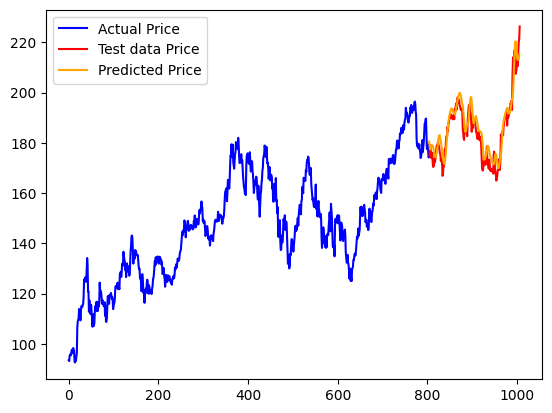

,Metric,Value
0,MAPE,2.07
1,MAE,3.78
2,MSE,22.96
3,RMSE,4.79
4,R2,0.85
5,SMAPE,2.04


In [6]:
a_stocks=data_util.stock_data('AAPL',4,'Apple')
y_pred,y_true=MultiLstm("AAPL",a_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df


[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.06912080198526382, 'val_loss': 0.04579152166843414}
Epoch 11 - {'loss': 0.002382311737164855, 'val_loss': 0.007885458879172802}
Epoch 21 - {'loss': 0.0018001378048211336, 'val_loss': 0.004155858885496855}
Epoch 31 - {'loss': 0.0015184904914349318, 'val_loss': 0.0017515051877126098}
Epoch 41 - {'loss': 0.0013307917397469282, 'val_loss': 0.0009374063811264932}
Epoch 51 - {'loss': 0.0011917685624212027, 'val_loss': 0.0012125121429562569}
Epoch 61 - {'loss': 0.0011503631249070168, 'val_loss': 0.0011696305591613054}
Epoch 71 - {'loss': 0.0009826275054365396, 'val_loss': 0.000738314411137253}
Epoch 81 - {'loss': 0.0008789255516603589, 'val_loss': 0.000659741519484669}
Epoch 91 - {'loss': 0.0008218149887397885, 'val_loss': 0.000487586366944015}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


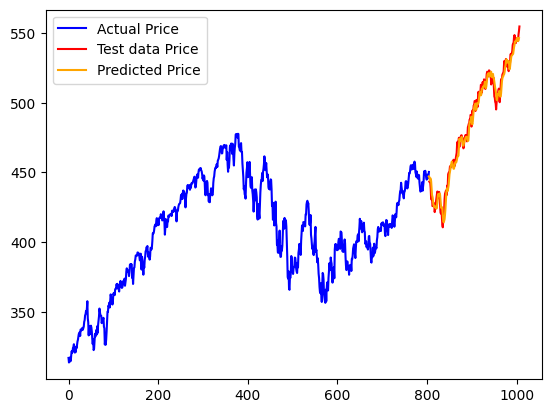

,Metric,Value
0,MAPE,0.85
1,MAE,4.07
2,MSE,26.77
3,RMSE,5.17
4,R2,0.98
5,SMAPE,0.85


In [7]:
s_stocks=data_util.stock_data('SPY', 4,'SPY')
y_pred,y_true=MultiLstm("SPY",s_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.03985663503408432, 'val_loss': 0.07206873595714569}
Epoch 11 - {'loss': 0.0009287504944950342, 'val_loss': 0.01221398077905178}
Epoch 21 - {'loss': 0.000849114905577153, 'val_loss': 0.011485802009701729}
Epoch 31 - {'loss': 0.00076246727257967, 'val_loss': 0.008807729929685593}
Epoch 41 - {'loss': 0.0007121971575543284, 'val_loss': 0.008143223822116852}
Epoch 51 - {'loss': 0.0007018216419965029, 'val_loss': 0.007550128735601902}
Epoch 61 - {'loss': 0.0006045789923518896, 'val_loss': 0.005090148188173771}
Epoch 71 - {'loss': 0.000535844243131578, 'val_loss': 0.006094034761190414}
Epoch 81 - {'loss': 0.000647442473564297, 'val_loss': 0.006117589771747589}
Epoch 91 - {'loss': 0.0004938035854138434, 'val_loss': 0.0062273903749883175}
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


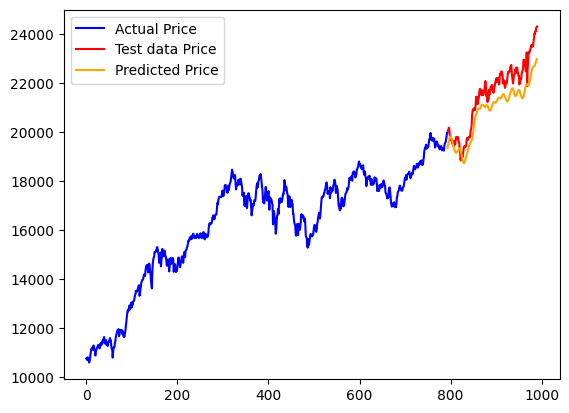

,Metric,Value
0,MAPE,3.10
1,MAE,679.84
2,MSE,577277.70
3,RMSE,759.79
4,R2,0.68
5,SMAPE,3.16


In [8]:
n_stocks=data_util.stock_data('^NSEI', 4,'Nifty 50')
y_pred,y_true=MultiLstm("^NSEI",n_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df

[*********************100%%**********************]  1 of 1 completed
c:\Users\baljyot\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1 - {'loss': 0.12577195465564728, 'val_loss': 0.004409412387758493}
Epoch 11 - {'loss': 0.00325641012750566, 'val_loss': 0.0023758397437632084}
Epoch 21 - {'loss': 0.0026707309298217297, 'val_loss': 0.0014300009934231639}
Epoch 31 - {'loss': 0.002437268616631627, 'val_loss': 0.0010220390977337956}
Epoch 41 - {'loss': 0.0021011908538639545, 'val_loss': 0.001430410542525351}
Epoch 51 - {'loss': 0.0018055266700685024, 'val_loss': 0.0010383680928498507}
Epoch 61 - {'loss': 0.001614017179235816, 'val_loss': 0.00130751496180892}
Epoch 71 - {'loss': 0.0014319870388135314, 'val_loss': 0.0009491294622421265}
Epoch 81 - {'loss': 0.0012770029716193676, 'val_loss': 0.0007564667612314224}
Epoch 91 - {'loss': 0.0013866020599380136, 'val_loss': 0.0006600278429687023}
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


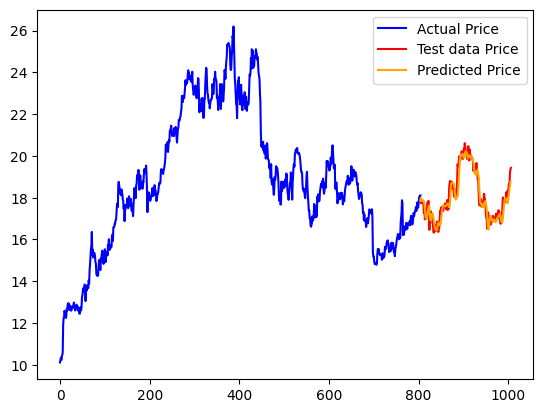

,Metric,Value
0,MAPE,1.61
1,MAE,0.29
2,MSE,0.15
3,RMSE,0.39
4,R2,0.88
5,SMAPE,1.62


In [9]:
i_stocks=data_util.stock_data('INFY', 4,'Infosys')
y_pred,y_true=MultiLstm("INFY",i_stocks,100)
styled_df = evaluate_metrics(y_true, y_pred)
styled_df